# Problem Statement

How can we identify malignant or benign tumor in a patient having breast cancer? What tools and methods can we use to arrive at an accurate diagnosis? What are the implications of developing such models and what scope do they have in the future?

---

### About The Dataset

1) ID number \
2) Diagnosis (M = malignant, B = benign)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)\
b) texture (standard deviation of gray-scale values) \
c) perimeter \
d) area \
e) smoothness (local variation in radius lengths) \
f) compactness (perimeter^2 / area - 1.0) \
g) concavity (severity of concave portions of the contour) \
h) concave points (number of concave portions of the contour) \
i) symmetry \
j) fractal dimension ("coastline approximation" - 1) \

In [1]:
pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.9-py3-none-any.whl size=184112 sha256=3c291a4216bca874df085983c3c2dd466e238e7cf2125b22f237b7c4ac3f9fe7
  Stored in directory: /root/.cache/pip/wheels/1b/9c/b8/9759d7cc64a1e01bb9872ade80cb7db445ccf506e083325106
Successfully built pyod


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from pyod.models.iforest import IForest

import warnings
warnings.filterwarnings('ignore')

**Data Cleaning & Prep Section:**
In this section, we focus on outlier detection & removal as well as checking for missing/inconsistent values

In [3]:
# load static data
df = pd.read_csv('data.csv')

df = df.drop('id', axis=1) # drop unnecessary ID column

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

print("Old shape:")
print(df.shape)

# working with multi-variate features that are interconnected, it is more difficult to detect outliers than univariate feature

isolate_df = df.loc[:, df.columns != 'diagnosis']

# using Isolation Forest to eliminate outliers

iforest = IForest(n_estimators=100).fit(isolate_df)

probs = iforest.predict_proba(isolate_df)

# set confidence threshold
# considering false positives costs' heavily in this case (medical), we set confidence to very high
threshold = 0.99

# create condition that returns True if probs is over threshold
is_outlier = probs[:, 1] > threshold
outliers_isolate_df_probs = isolate_df[is_outlier]

# Count up the outliers
num_outliers = len(outliers_isolate_df_probs)
print("---------------")
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(isolate_df):.4f}")

outlier_column = pd.DataFrame(is_outlier, columns=['is_outlier'])

df = pd.concat([df, outlier_column], axis=1, join='inner')

# removing outliers from dataframe
df = df[df.is_outlier == False]

df = df.drop('is_outlier', axis=1)

print("---------------")
print("New shape:")
print(df.shape)

Old shape:
(569, 31)
---------------
The number of outliers: 2
Percentage of outliers: 0.0035
---------------
New shape:
(567, 31)


In [4]:
# now that outlier has been addressed, we now check the summary statistics/information
df.info()

# no NA/NULL values found and features are of correct data type

<class 'pandas.core.frame.DataFrame'>
Int64Index: 567 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                567 non-null    object 
 1   radius_mean              567 non-null    float64
 2   texture_mean             567 non-null    float64
 3   perimeter_mean           567 non-null    float64
 4   area_mean                567 non-null    float64
 5   smoothness_mean          567 non-null    float64
 6   compactness_mean         567 non-null    float64
 7   concavity_mean           567 non-null    float64
 8   concave points_mean      567 non-null    float64
 9   symmetry_mean            567 non-null    float64
 10  fractal_dimension_mean   567 non-null    float64
 11  radius_se                567 non-null    float64
 12  texture_se               567 non-null    float64
 13  perimeter_se             567 non-null    float64
 14  area_se                  5

**EDA Section:**
In this section, we focus on descriptive analysis, correlation analysis and checking imbalance of the data

1) Descriptive Analysis

In [5]:
#Creating a data list containing all variables. As seen above, all the variables are numerical features. 
variables_list = ["radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean", "compactness_mean", "concavity_mean", "concave points_mean",
"symmetry_mean", "fractal_dimension_mean", "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se", "compactness_se", "concavity_se", "concave points_se", 
"symmetry_se", "fractal_dimension_se", "radius_worst", "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst", "compactness_worst", "concavity_worst", 
"concave points_worst", "symmetry_worst", "fractal_dimension_worst"]
data_list = pd.DataFrame(df[variables_list])

# Summary Statistics for all Variables
data_list.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
radius_mean,567.0,14.12,3.50,6.98,11.70,13.37,15.78,28.11
texture_mean,567.0,19.30,4.31,9.71,16.18,18.84,21.80,39.28
perimeter_mean,567.0,91.89,24.11,43.79,75.19,86.24,103.95,188.50
area_mean,567.0,653.56,349.14,143.50,420.30,551.10,782.65,2501.00
smoothness_mean,567.0,0.10,0.01,0.05,0.09,0.10,0.11,0.16
compactness_mean,567.0,0.10,0.05,0.02,0.06,0.09,0.13,0.35
concavity_mean,567.0,0.09,0.08,0.00,0.03,0.06,0.13,0.43
concave points_mean,567.0,0.05,0.04,0.00,0.02,0.03,0.07,0.19
symmetry_mean,567.0,0.18,0.03,0.11,0.16,0.18,0.20,0.30
fractal_dimension_mean,567.0,0.06,0.01,0.05,0.06,0.06,0.07,0.10


In [6]:
'''Skewness of the variables. Most of the variables are positively skewed, so we can analyse whether log transforming the variables 
to reduce the skew will affect the accuracy of the machine learning model that we will train later'''
data_list.skew()

radius_mean                0.934939
texture_mean               0.648443
perimeter_mean             0.978729
area_mean                  1.648223
smoothness_mean            0.418594
compactness_mean           1.177087
concavity_mean             1.306195
concave points_mean        1.133521
symmetry_mean              0.699124
fractal_dimension_mean     1.252190
radius_se                  3.143815
texture_se                 1.651972
perimeter_se               3.498601
area_se                    5.590313
smoothness_se              2.240777
compactness_se             1.870054
concavity_se               3.251026
concave points_se          1.088050
symmetry_se                2.230133
fractal_dimension_se       3.054273
radius_worst               1.109200
texture_worst              0.493931
perimeter_worst            1.133491
area_worst                 1.872966
smoothness_worst           0.417883
compactness_worst          1.479892
concavity_worst            1.159664
concave points_worst       0

In [7]:
'''Though the degree of spread for most of the variables are minimal, some variables such as area possess high variance, 
which means that the degree of spread from the mean is really high'''
#Variance of the individual variables
data_list.var()

radius_mean                    12.247513
texture_mean                   18.535222
perimeter_mean                581.380911
area_mean                  121895.507683
smoothness_mean                 0.000194
compactness_mean                0.002735
concavity_mean                  0.005991
concave points_mean             0.001468
symmetry_mean                   0.000732
fractal_dimension_mean          0.000048
radius_se                       0.074703
texture_se                      0.295257
perimeter_se                    4.014442
area_se                      2010.875534
smoothness_se                   0.000009
compactness_se                  0.000304
concavity_se                    0.000663
concave points_se               0.000035
symmetry_se                     0.000067
fractal_dimension_se            0.000006
radius_worst                   23.226041
texture_worst                  37.837110
perimeter_worst              1121.217676
area_worst                 322357.399708
smoothness_worst

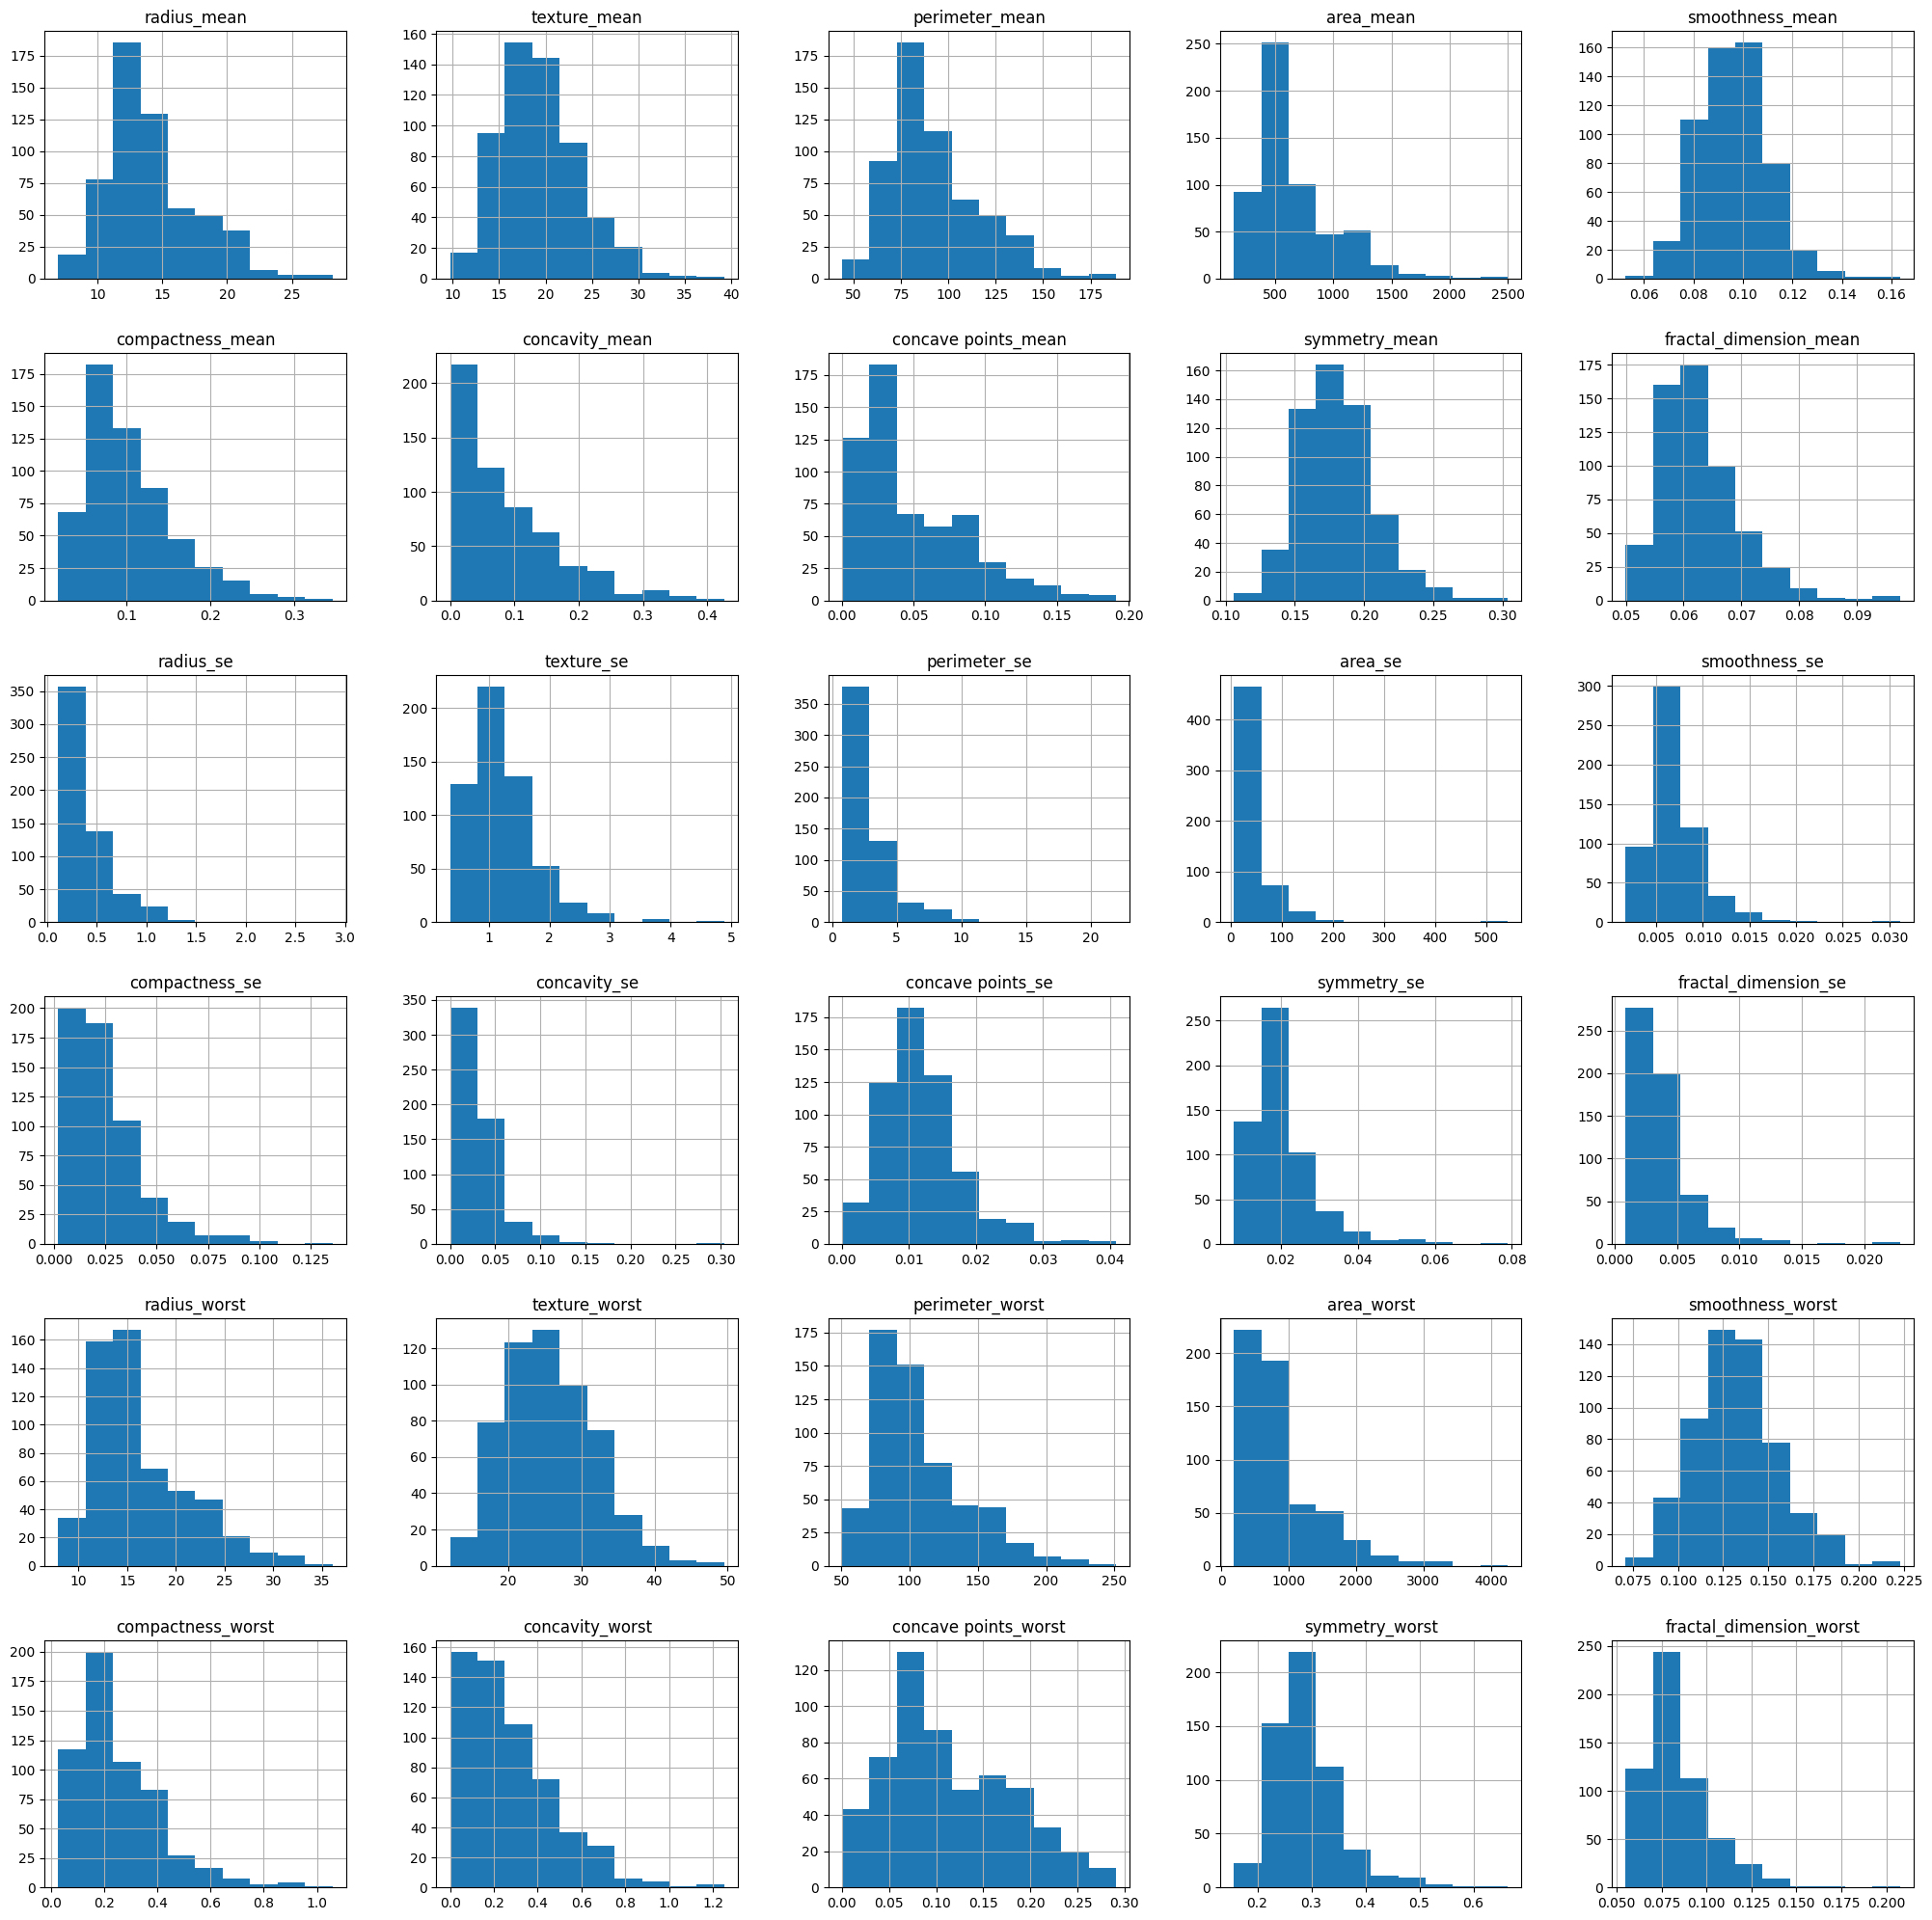

In [8]:
#To create a histogram and density plot that will help us to find the distribution and outliers of every variable.
'''Most of the mean variables possess a distribution similar to the normal distribution. However, most of the variables are right-skewed and this can be verified visually using the histogram and the skewness above. 
However, implementing log transformation will be hard as some variables such as concavity_mean has positive skewness but it has datapoints that are 0'''

data_list.hist(figsize=(25,25), layout=(6,5))
plt.show()

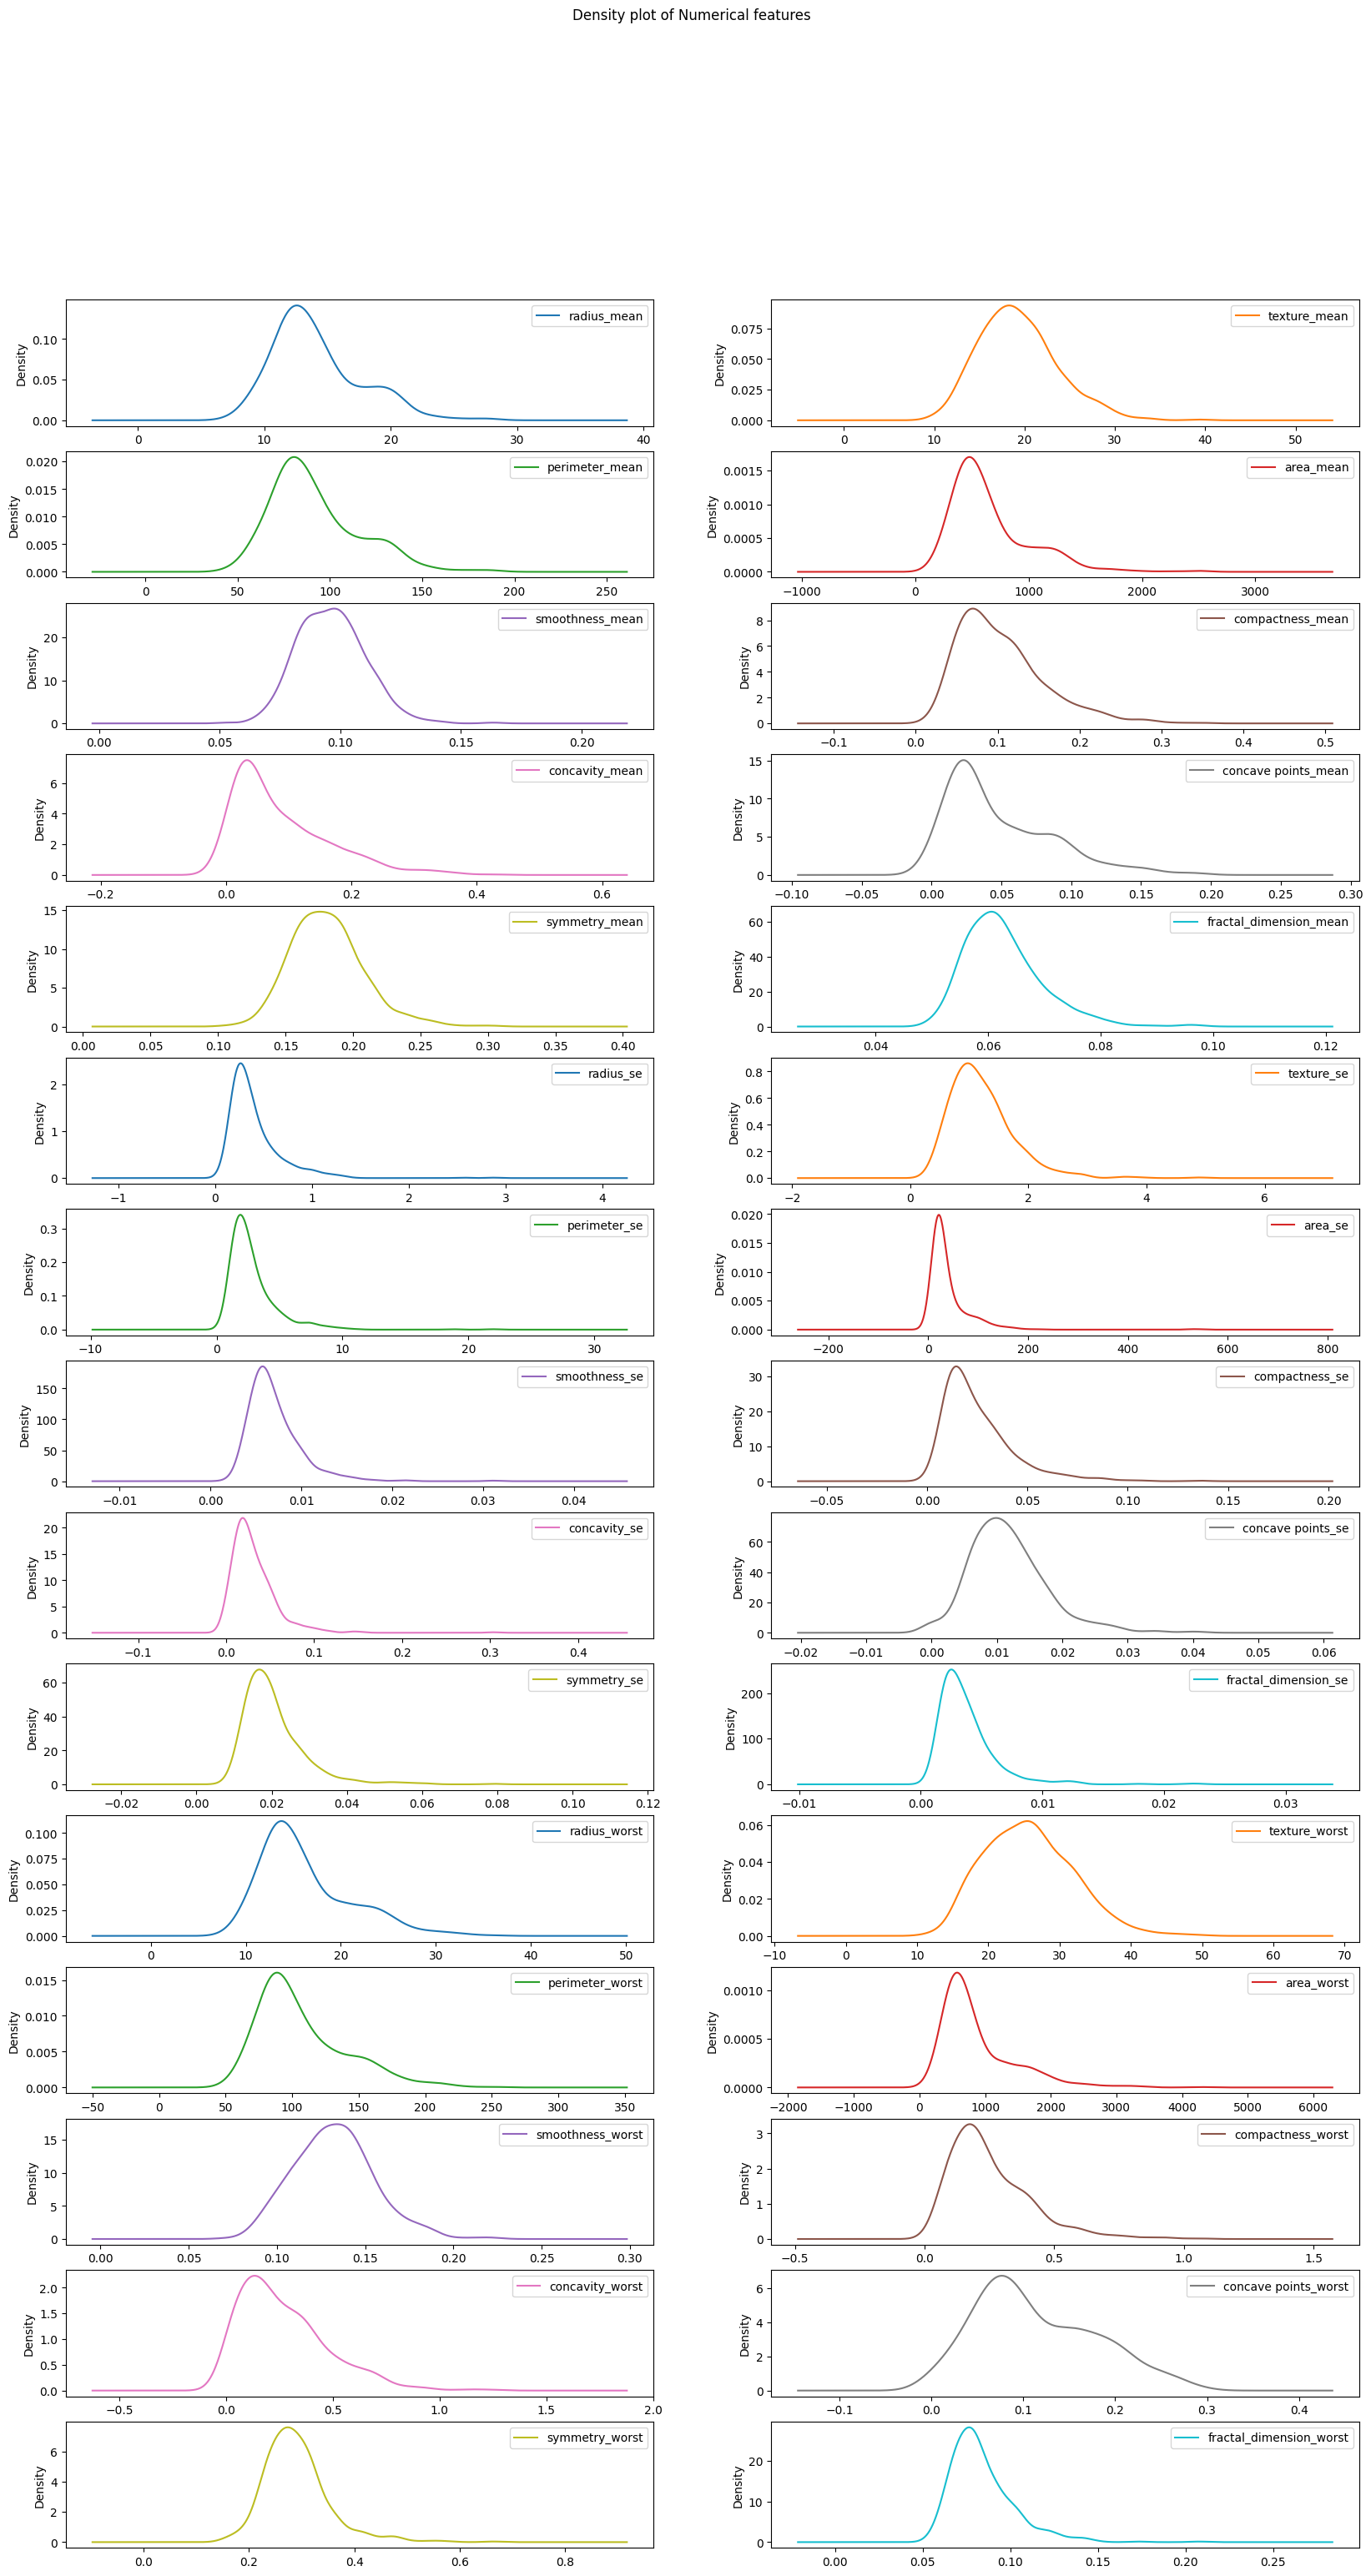

In [9]:
data_list.plot(kind='density',figsize=(20,35),subplots=True,layout=(15,2),title="Density plot of Numerical features",sharex=False)
plt.show()

2) Correlation Analysis

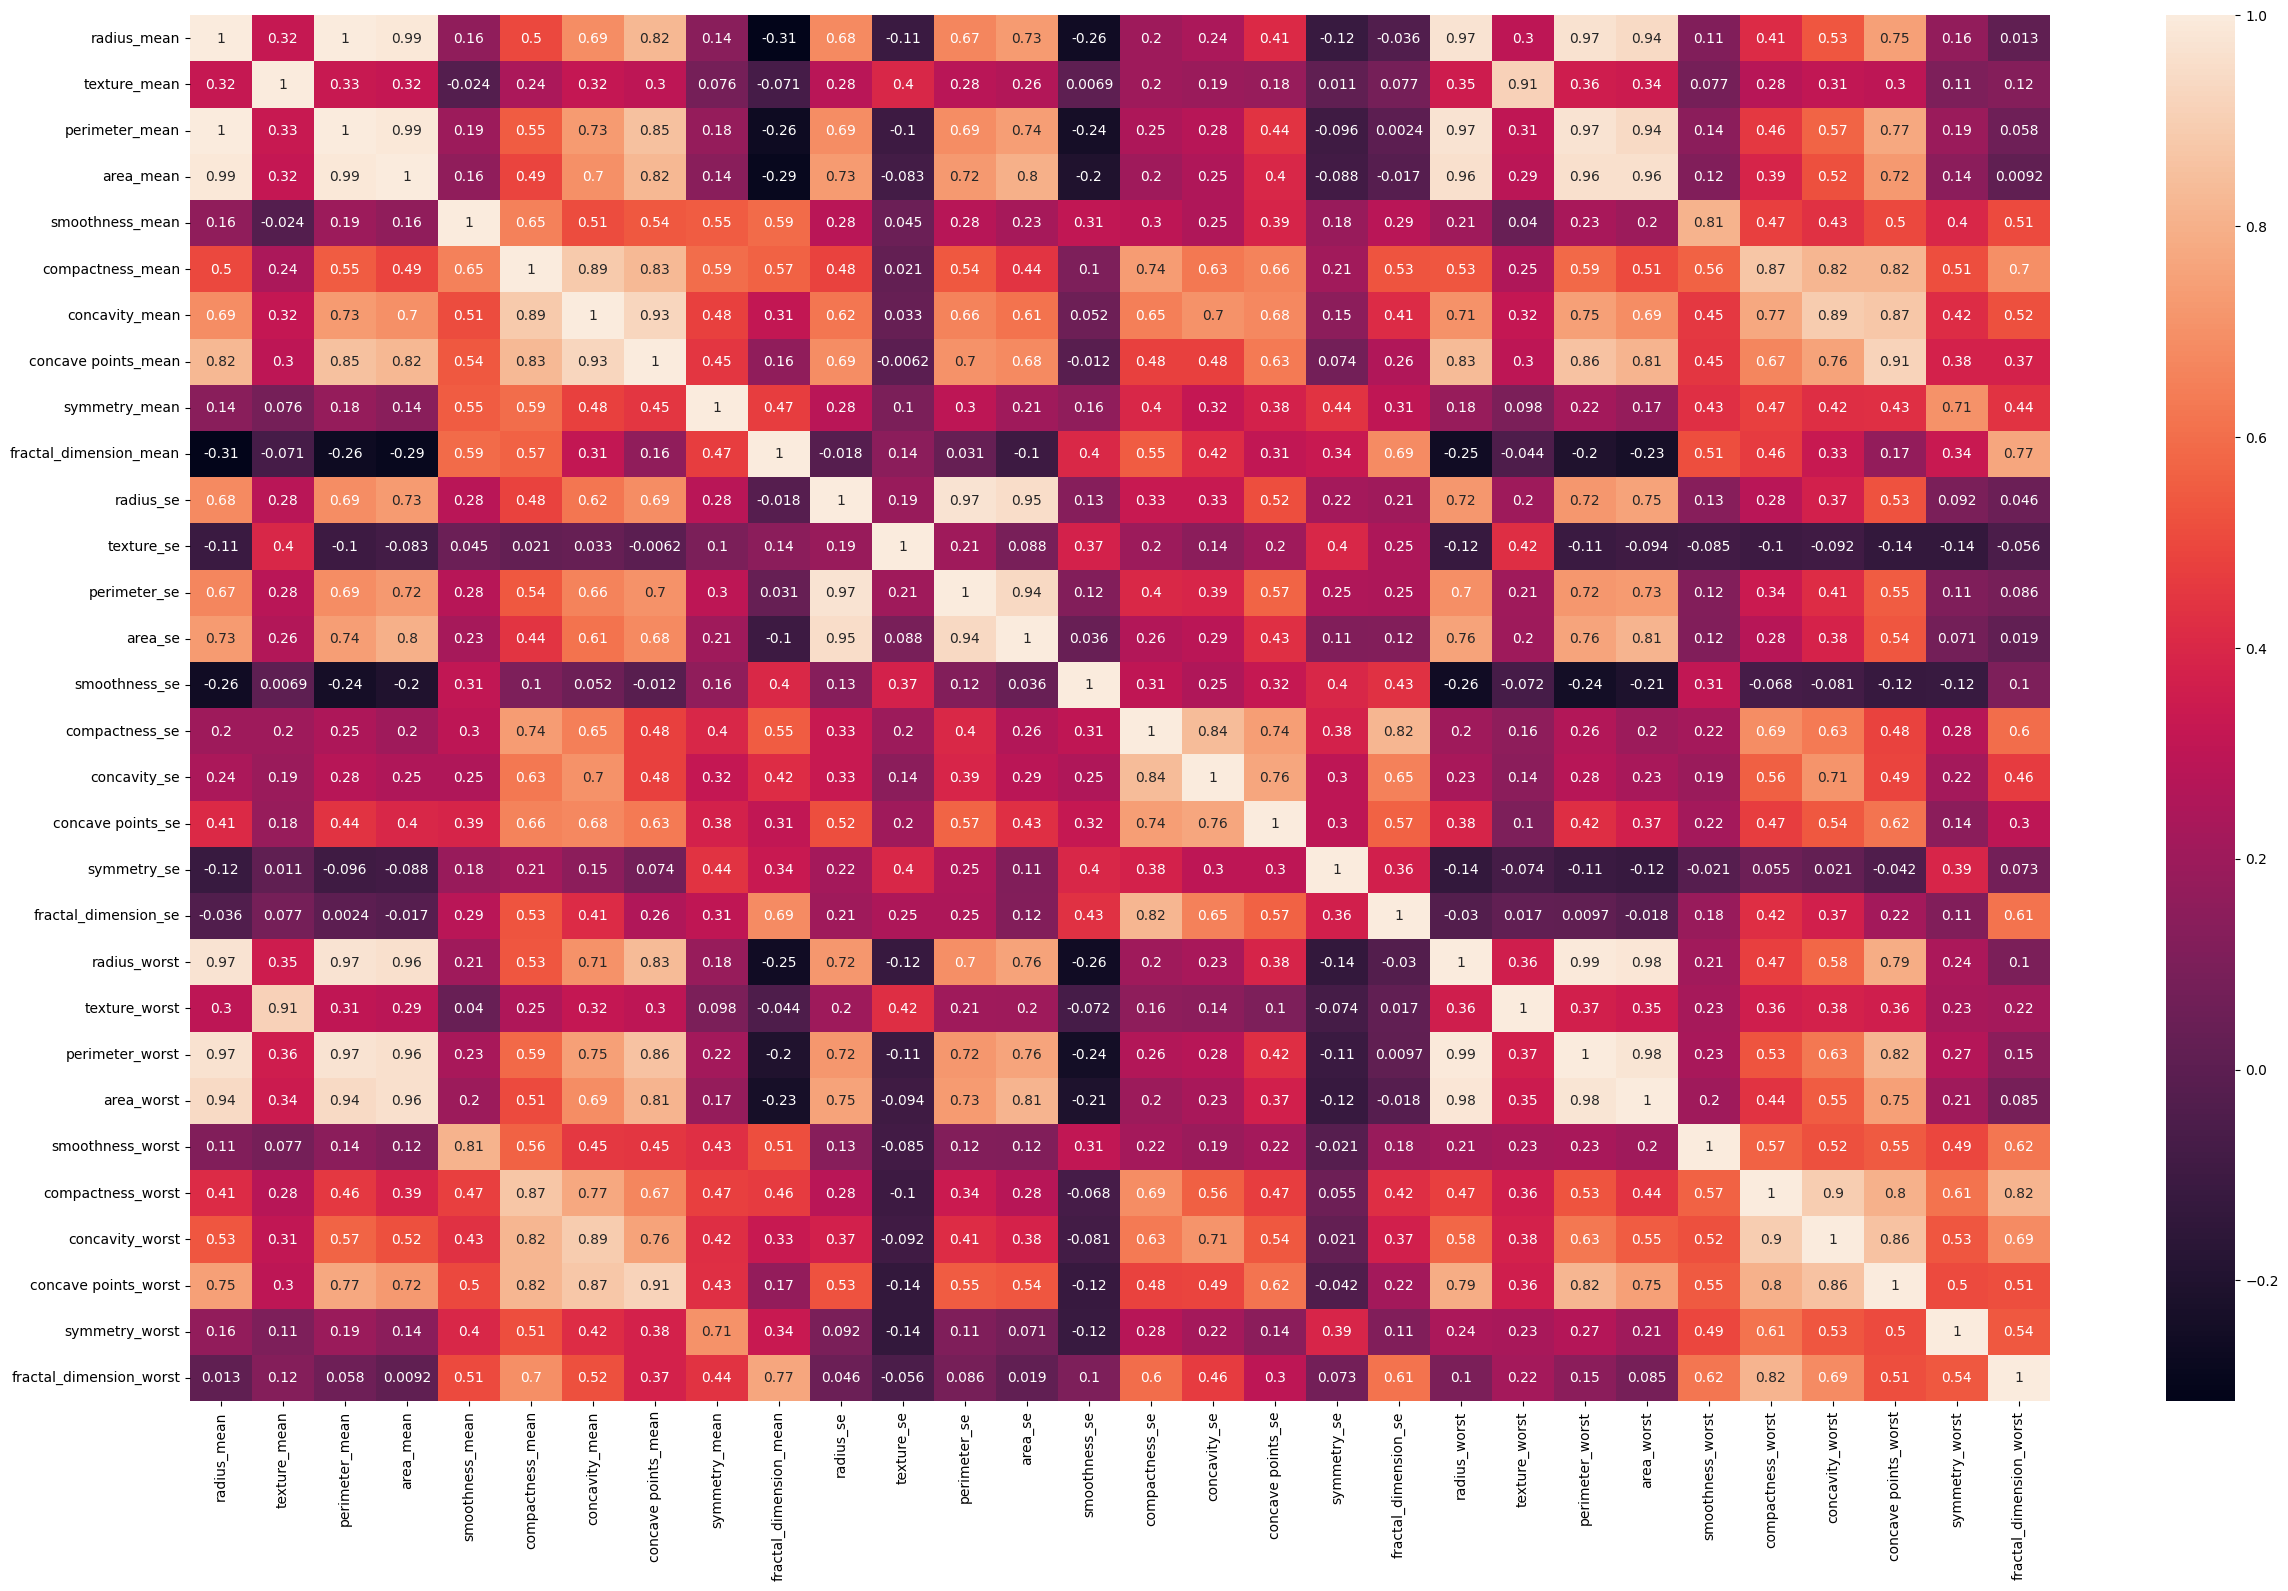

In [10]:
# Plot correlation matrix in heatmap
fig, ax = plt.subplots(figsize=(30, 18))
sb.heatmap(data_list.corr(), ax=ax, annot=True)
plt.show()

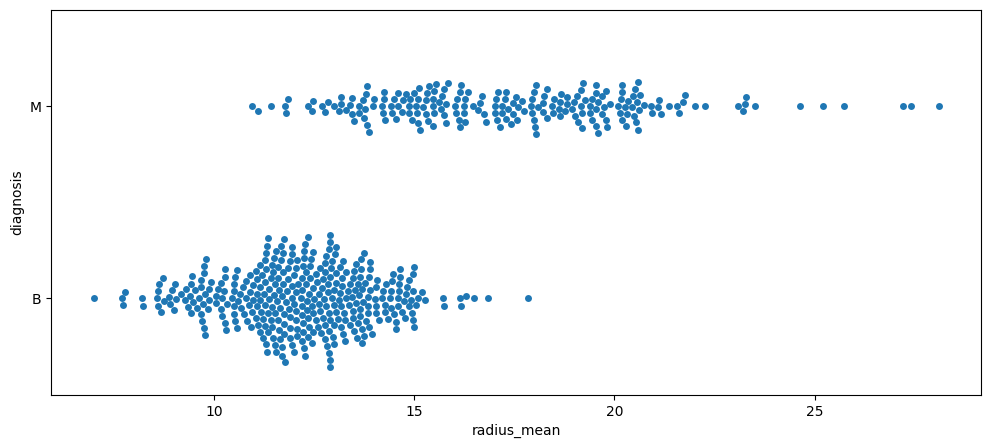

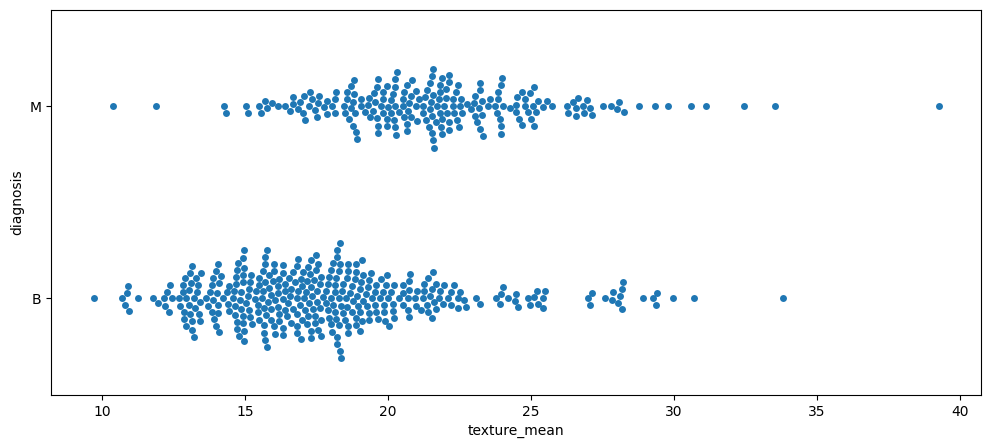

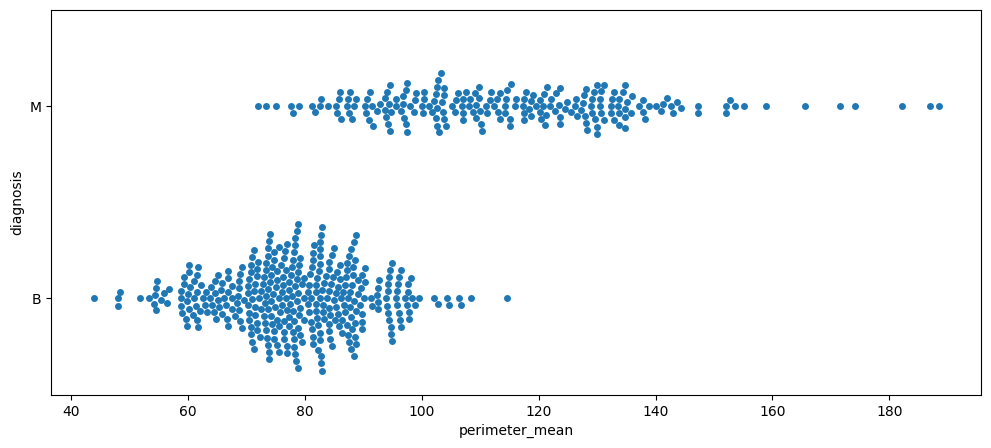

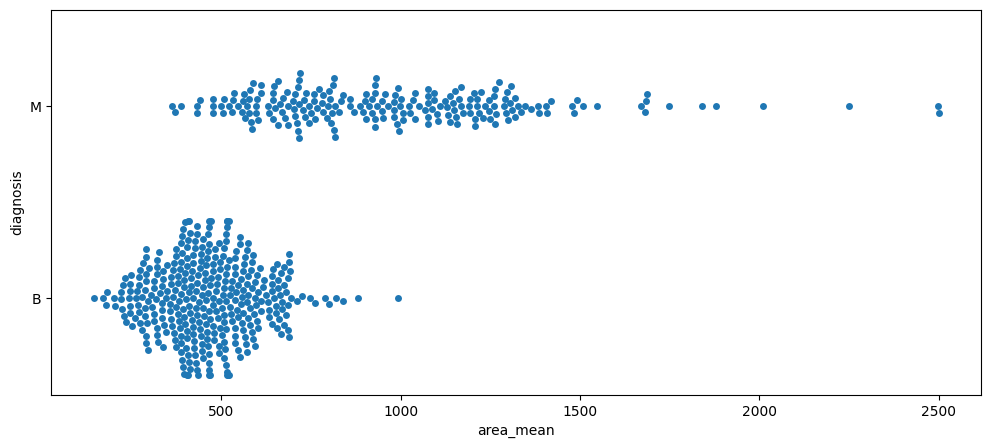

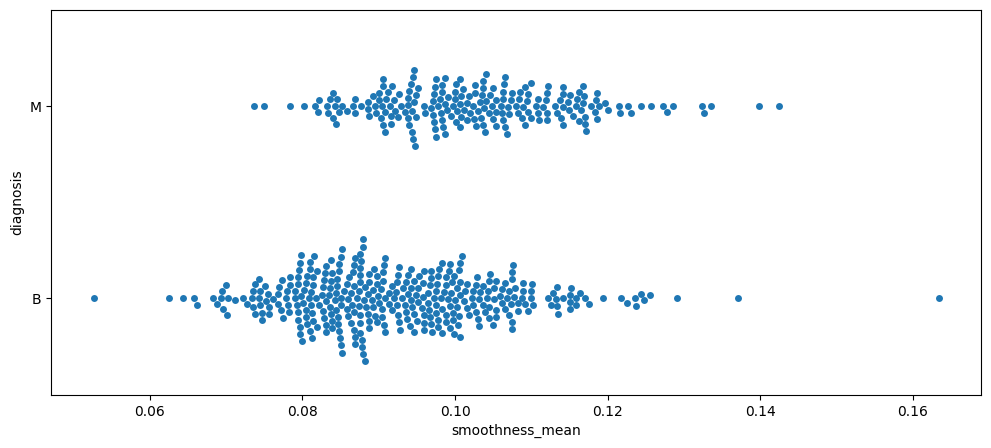

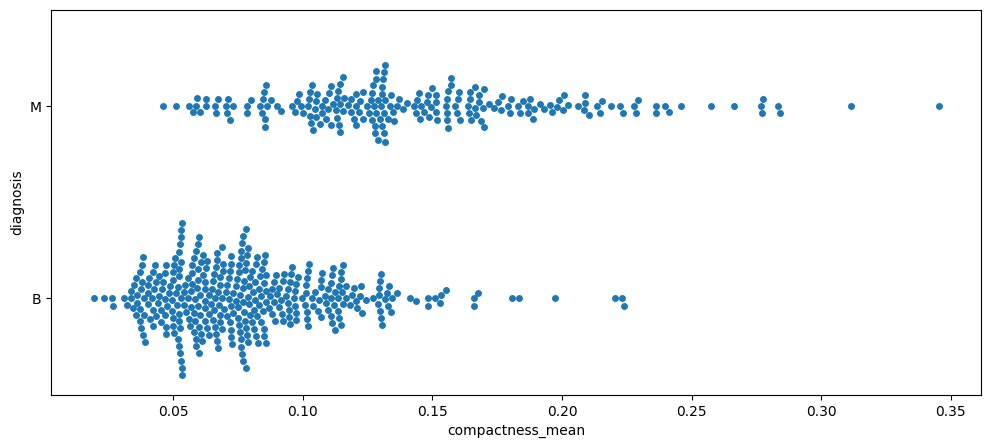

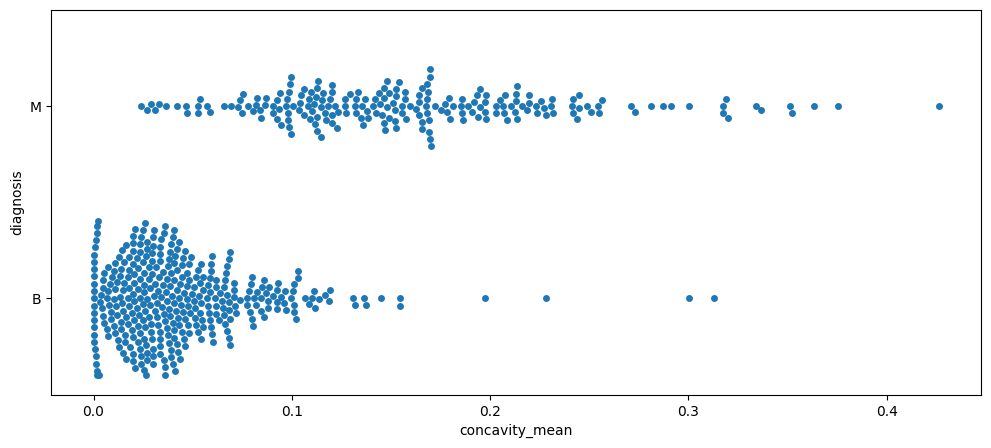

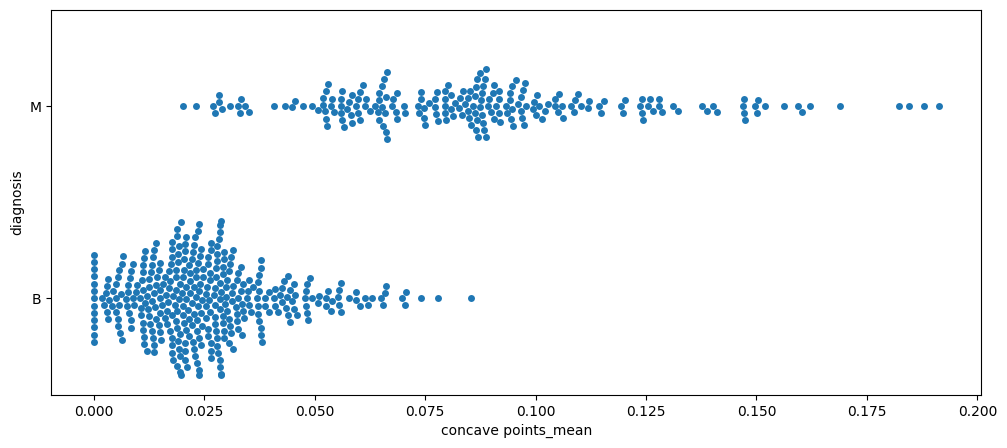

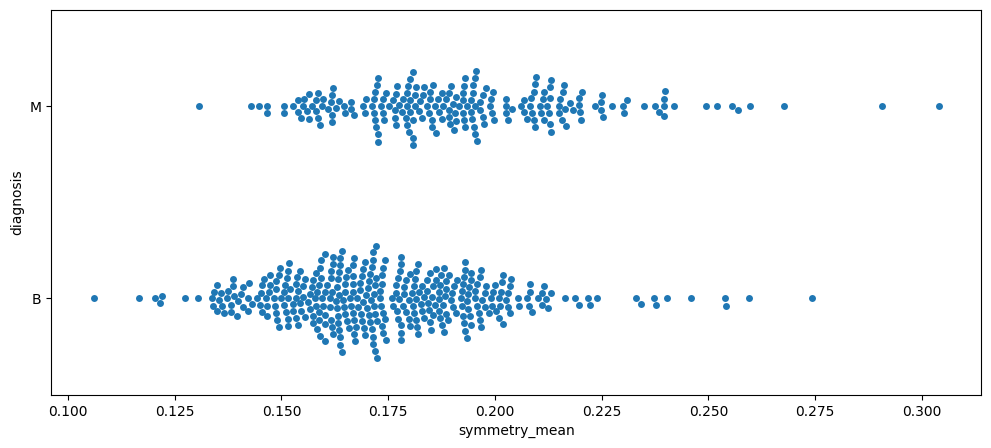

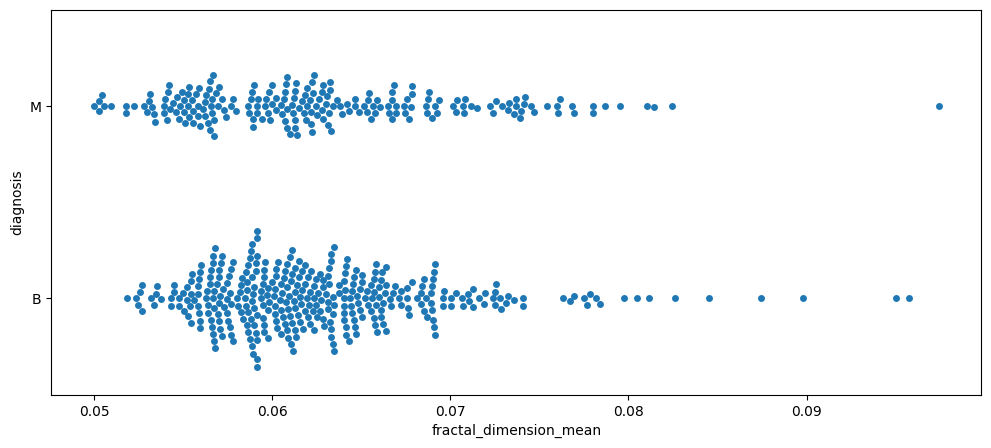

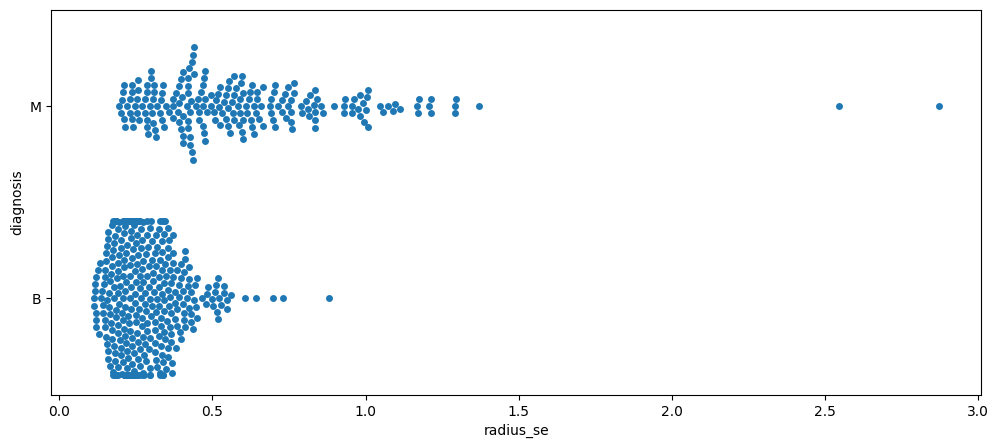

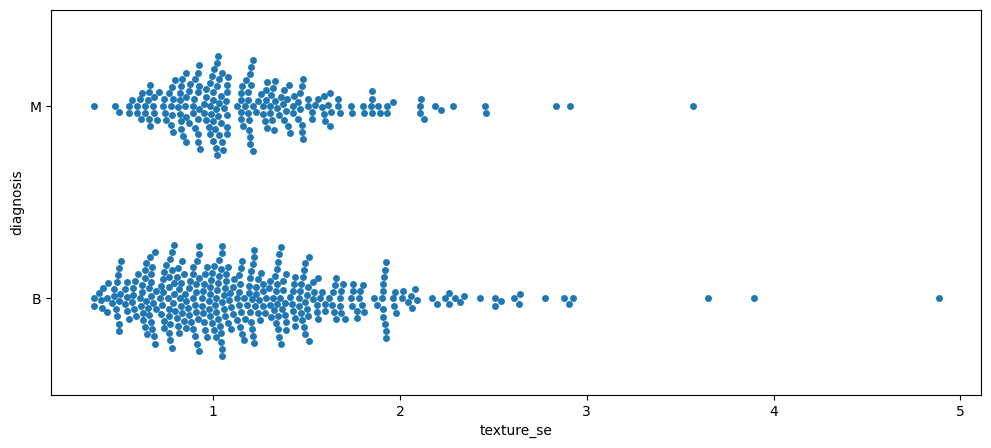

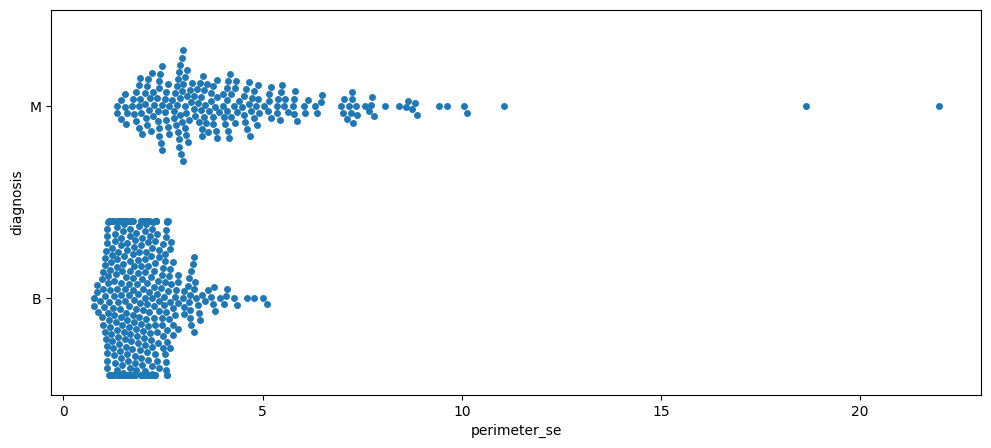

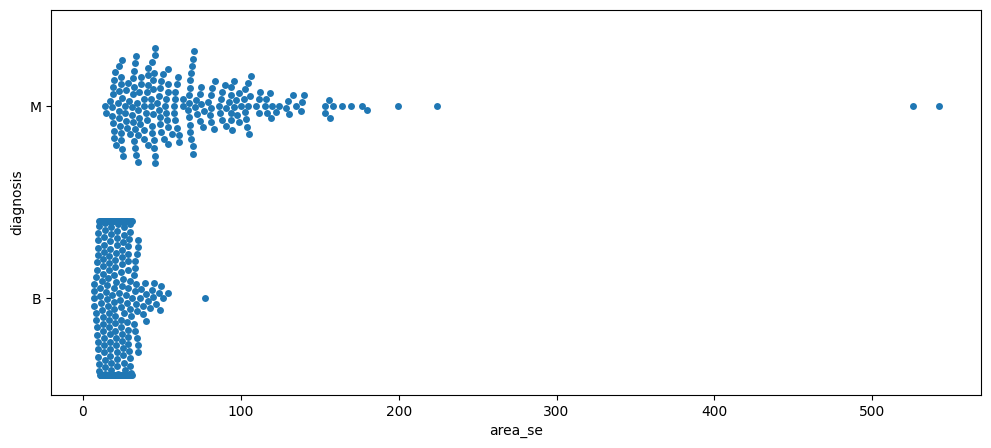

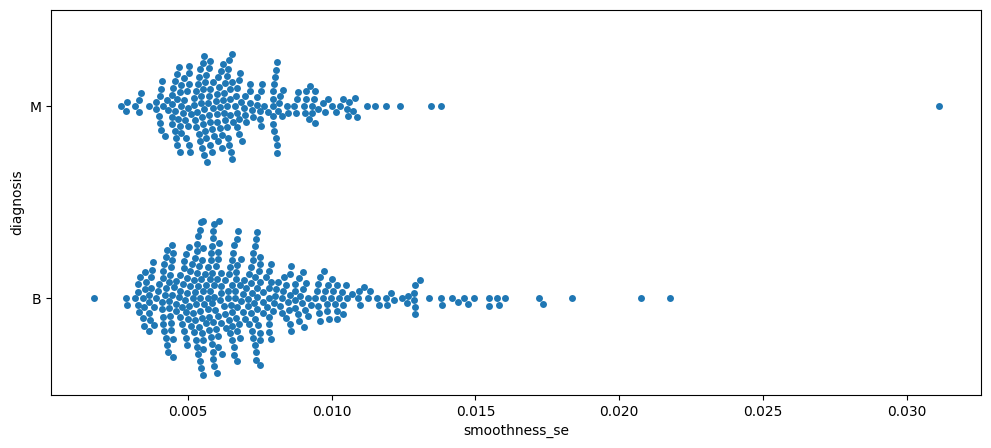

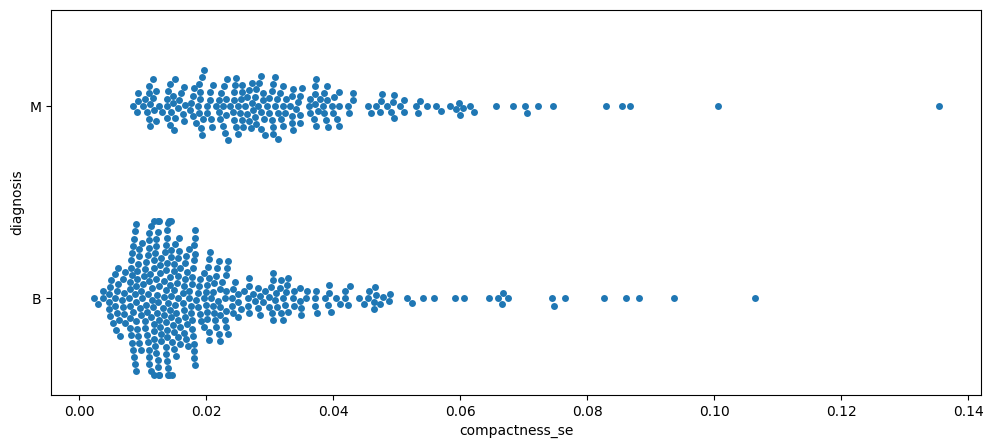

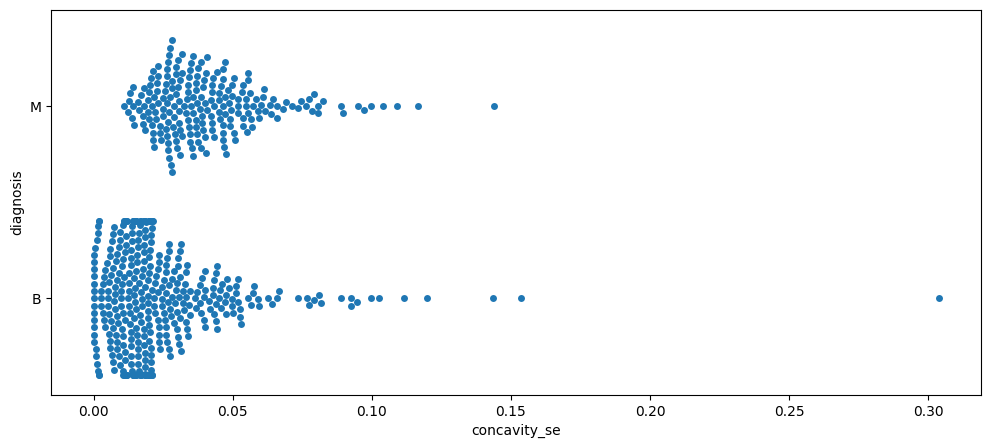

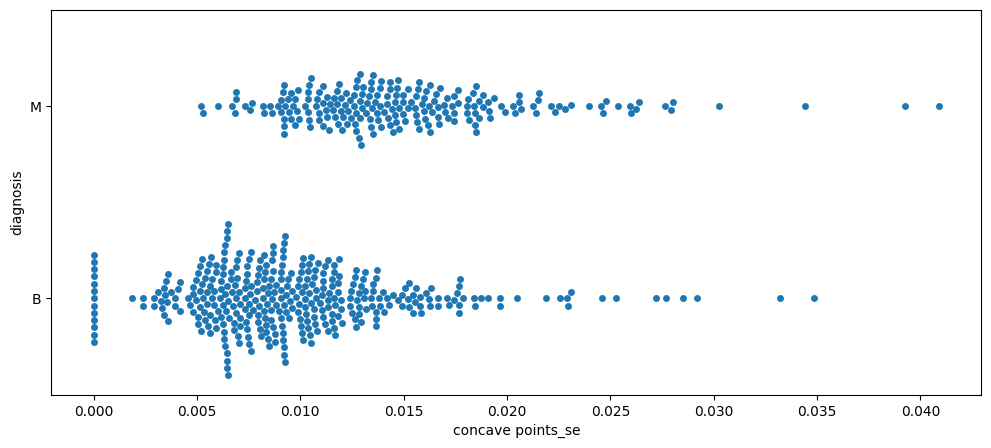

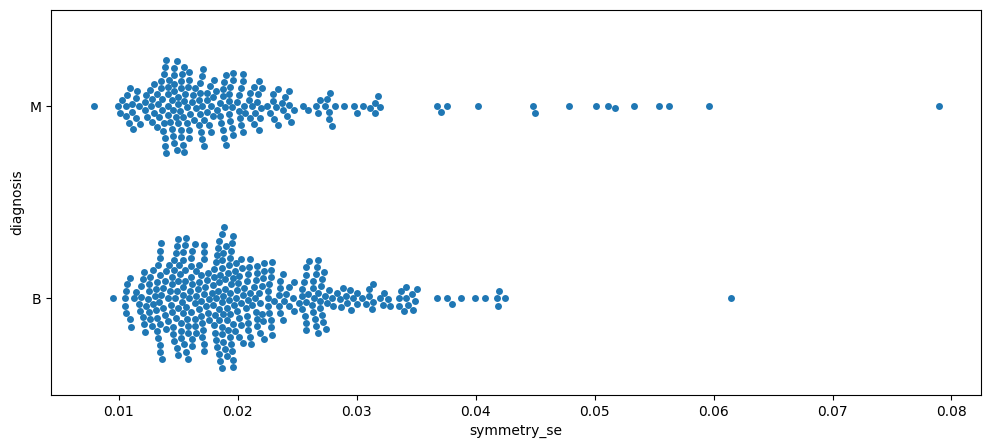

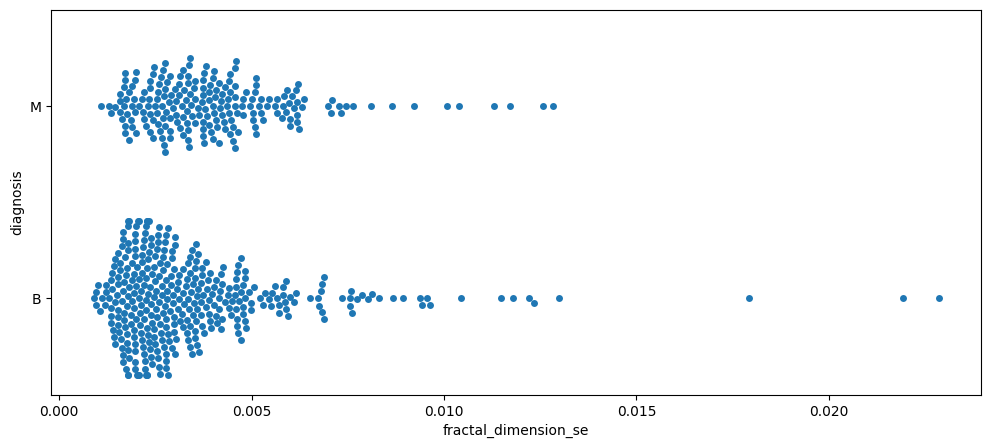

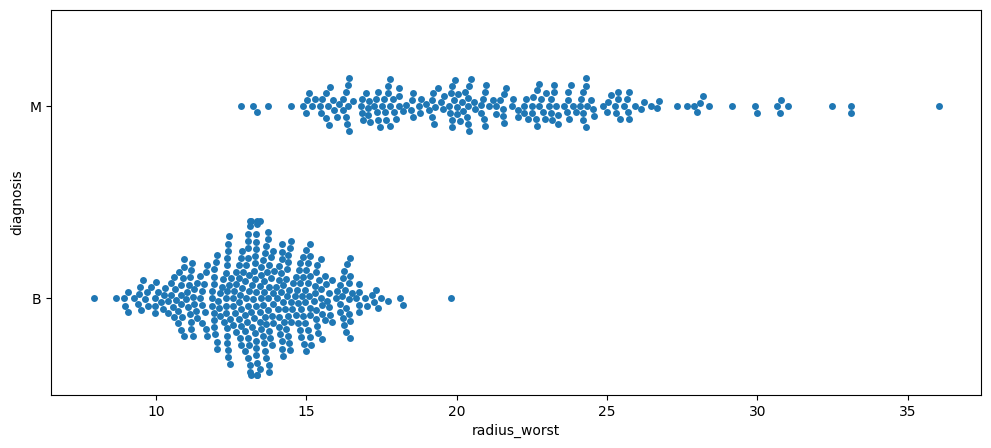

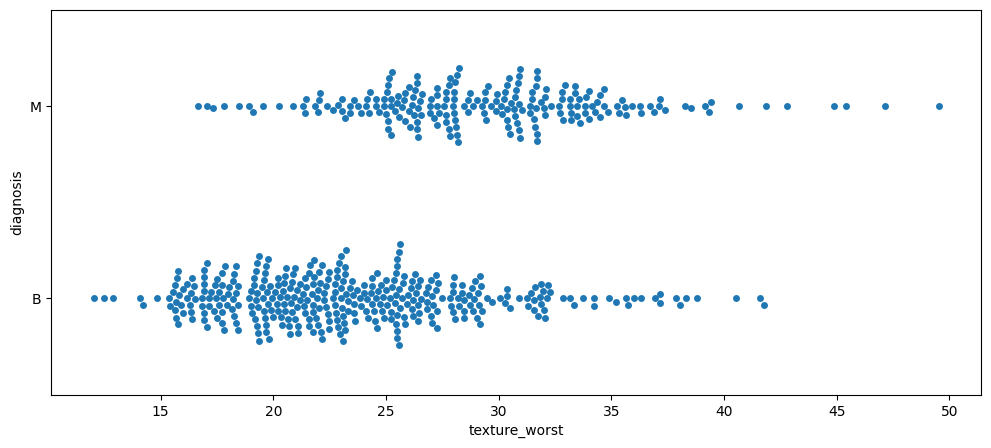

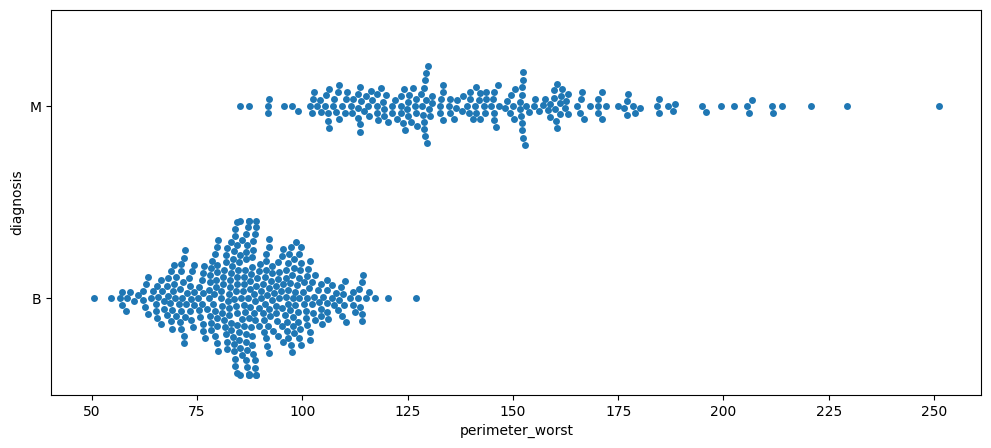

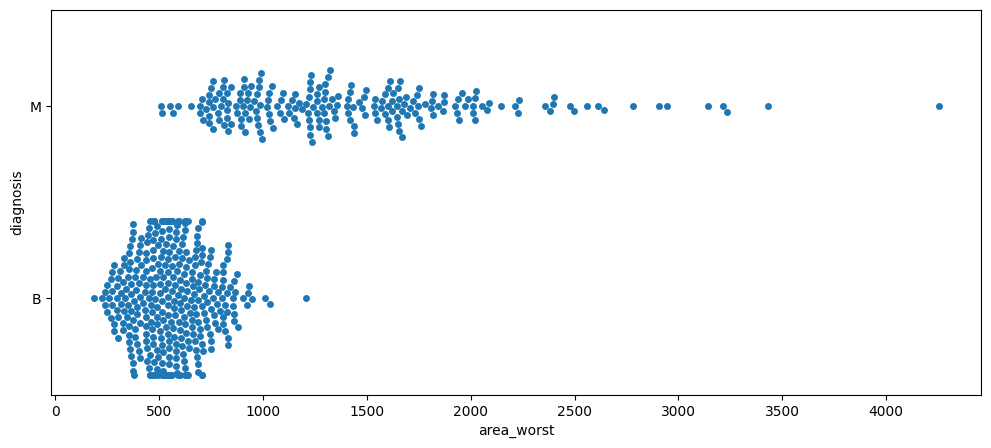

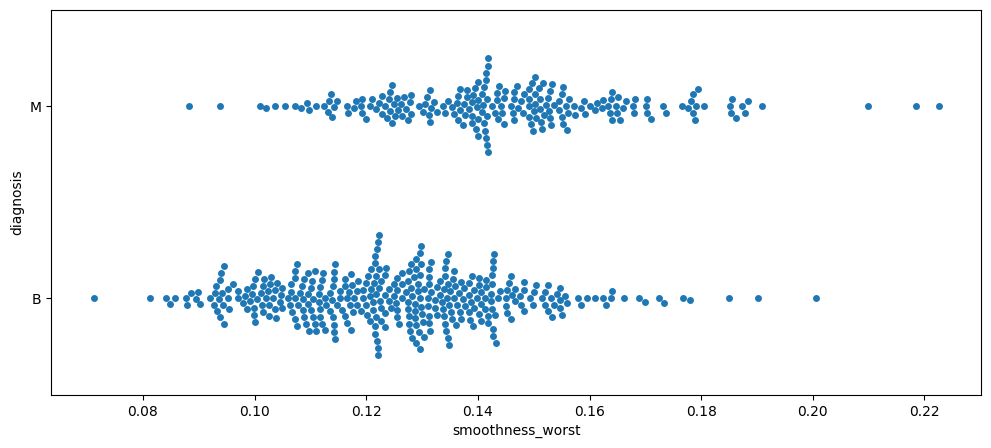

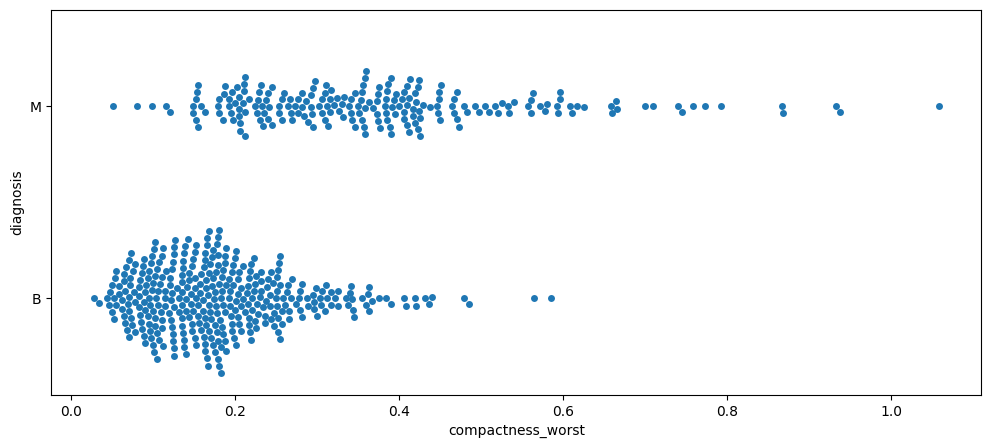

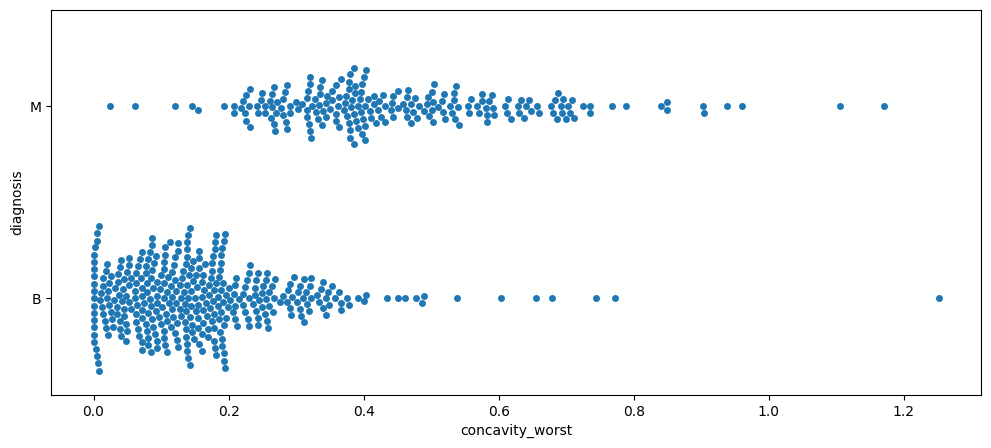

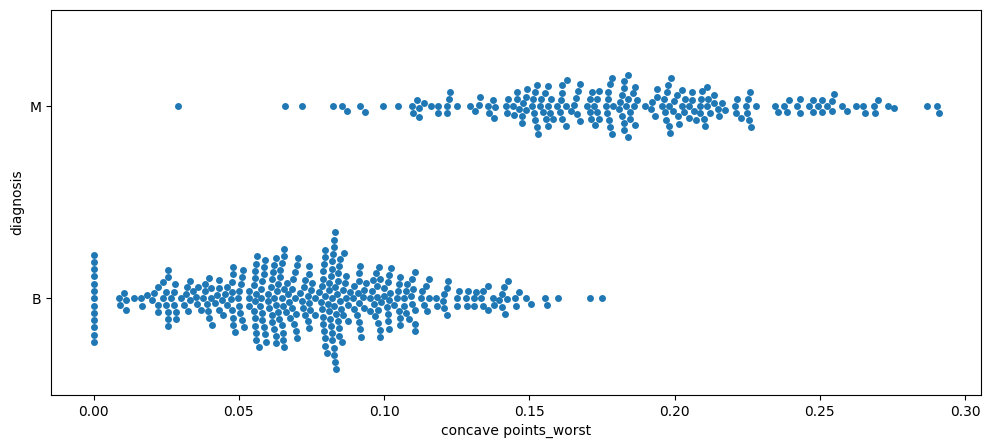

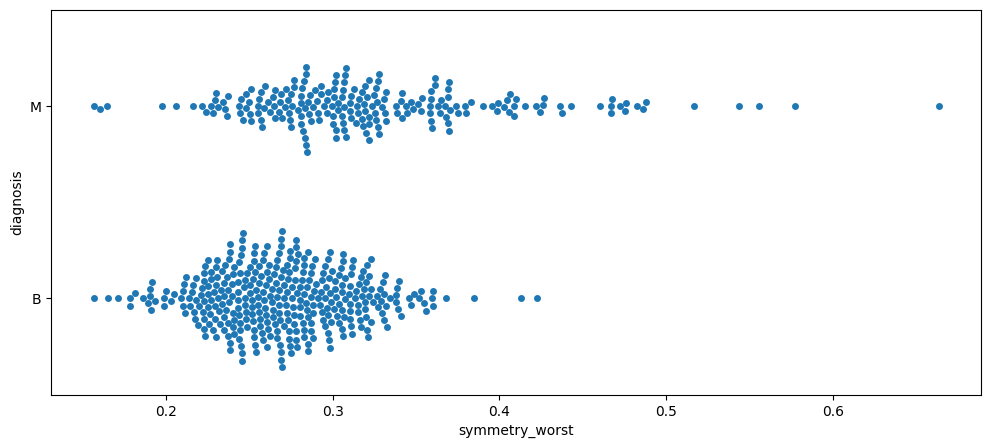

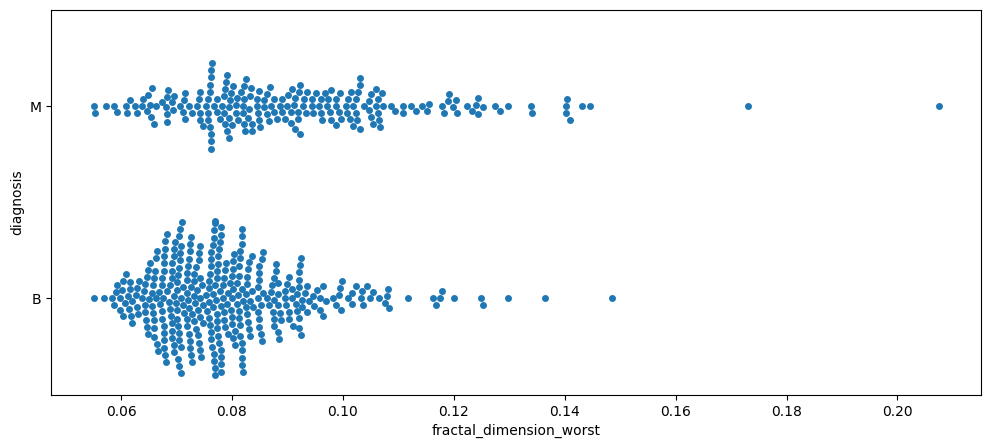

In [11]:
# To plot swarmplot for all 30 variables
'''The mean variables show that the datapoints can be distinguishable using malignant or benign. For example, radius_mean, perimeter_mean and area_mean clearly shows that some of the datapoints were cluttered on one class.
However, when we take a look at the se variables, the datapoints seem to be cluttered on the same line so it will be difficult to distinguish between malignant or benign using se and worst as much as using mean.'''
diagnosis = pd.DataFrame(df['diagnosis'])
variables_list = ["radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean", "compactness_mean", "concavity_mean", "concave points_mean",
"symmetry_mean", "fractal_dimension_mean", "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se", "compactness_se", "concavity_se", "concave points_se", 
"symmetry_se", "fractal_dimension_se", "radius_worst", "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst", "compactness_worst", "concavity_worst", 
"concave points_worst", "symmetry_worst", "fractal_dimension_worst"]

for variable in variables_list:
  variable_con = pd.DataFrame(df[variable])   
  mean_diagnosis = pd.concat([variable_con, diagnosis], axis = 1).reindex(variable_con.index)
  f = plt.figure(figsize=(12, 5))
  sb.swarmplot(x = variable, y = "diagnosis", data = mean_diagnosis, orient = "h")

3) Imbalance in Data

In [12]:
'''We need to check the imbalance in the data as we are working on a classification problem. The code is given below'''

#group instances based on the classes in 'diagnosis' variable
#malignant is 1, benign is 0

class_counts=df.groupby("diagnosis").size()

columns=['diagnosis','count','percentage']
outcome=[0,1]
count=list()
percentage=list()

#Calculate the percentage of each value of the OUTCOME variable from total
for val in range(2):
    count.append(class_counts[val])
    percent=(class_counts[val]/len(df))*100
    percentage.append(percent)

# Convert the calulated values into a dataframe
imbalance_df=pd.DataFrame(list(zip(outcome,count,percentage)),columns=columns)
imbalance_df   

,diagnosis,count,percentage
0,0,356,62.786596
1,1,211,37.213404


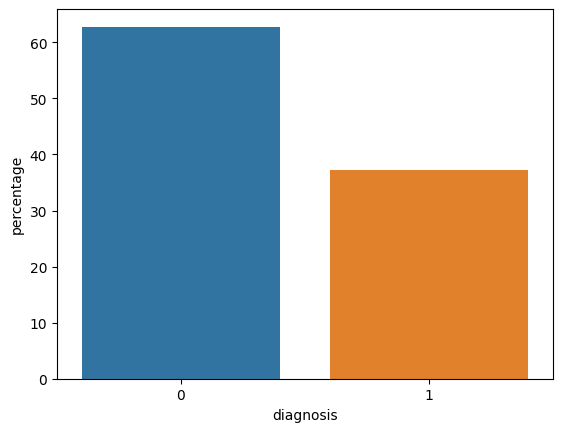

In [13]:
sb.barplot(data=imbalance_df,x=imbalance_df['diagnosis'],y=imbalance_df['percentage'])
plt.show()

Conclusion you can write from the imbalance of data as seen above: There is imbalance between two classes (approx 25% difference).So consider adapting performance metrics like "recall", "precision" and "f1 score" instead of "accurary" to assess the ML model. Also check if the imbalance data affects the performance of the machine learning model

### Splitting and Preprocessing Data

We start by importing the necessary libraries and splitting the dataset into training (70%) and testing (30%) sets. We then standardize the features for better model performance.

In [19]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define the features and target variables
X = data_list
y = df["diagnosis"]

# Split the dataset into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Functions and Evaluation

We create functions for six different machine learning models: K Nearest Neighbors, Decision Trees, Random Forest, Support Vector Machines, Naive Bayes, and Logistic Regression. These functions fit the models to the training data, make predictions on the test data, and return the accuracy score.

In [20]:
def k_nearest_neighbors(X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    return accuracy_score(y_test, y_pred_knn)

def decision_tree(X_train, X_test, y_train, y_test):
    dt = DecisionTreeClassifier(random_state=0)
    dt.fit(X_train, y_train)
    y_pred_dt = dt.predict(X_test)
    return accuracy_score(y_test, y_pred_dt)

def random_forest(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(random_state=0)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    return accuracy_score(y_test, y_pred_rf)

def support_vector_machine(X_train, X_test, y_train, y_test):
    svm = SVC(kernel='linear', random_state=0)
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_test)
    return accuracy_score(y_test, y_pred_svm)

def naive_bayes(X_train, X_test, y_train, y_test):
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_pred_gnb = gnb.predict(X_test)
    return accuracy_score(y_test, y_pred_gnb)

def logistic_regression(X_train, X_test, y_train, y_test):
    lr = LogisticRegression(random_state=0)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    return accuracy_score(y_test, y_pred_lr)

# Call the functions and print the test accuracies
print(f"K Nearest Neighbor Accuracy: {k_nearest_neighbors(X_train, X_test, y_train, y_test):.2f}")
print(f"Decision Tree Accuracy: {decision_tree(X_train, X_test, y_train, y_test):.2f}")
print(f"Random Forest Accuracy: {random_forest(X_train, X_test, y_train, y_test):.2f}")
print(f"SVM Accuracy: {support_vector_machine(X_train, X_test, y_train, y_test):.2f}")
print(f"Naive Bayes Accuracy: {naive_bayes(X_train, X_test, y_train, y_test):.2f}")
print(f"Logistic Regression Accuracy: {logistic_regression(X_train, X_test, y_train, y_test):.2f}")

K Nearest Neighbor Accuracy: 0.96
Decision Tree Accuracy: 0.95
Random Forest Accuracy: 0.95
SVM Accuracy: 0.97
Naive Bayes Accuracy: 0.94
Logistic Regression Accuracy: 0.98


The above code trains each model on the training dataset, makes predictions on the test dataset, and calculates the test accuracy for each model. By comparing the accuracy scores, we can determine which model performs best on this breast cancer detection dataset.

### Model Evaluation

We will evaluate each of the models based on their accuracy, True Positive Rate (TPR), and False Positive Rate (FPR). Our goal is to minimize the False Negatives (FN), as a high TPR is essential for cancer detection.

To achieve this, we will calculate the TPR, FPR, and accuracy for each model and display the results in a table format.

In [22]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix

# Create a function to calculate TPR and FPR
def tpr_fpr(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr

# Get TPR, FPR and accuracy for each model
models = ["K Nearest Neighbor", "Decision Tree", "Random Forest", "SVM", "Naive Bayes", "Logistic Regression"]
accuracies = [
    k_nearest_neighbors(X_train, X_test, y_train, y_test),
    decision_tree(X_train, X_test, y_train, y_test),
    random_forest(X_train, X_test, y_train, y_test),
    support_vector_machine(X_train, X_test, y_train, y_test),
    naive_bayes(X_train, X_test, y_train, y_test),
    logistic_regression(X_train, X_test, y_train, y_test),
]
tpr_fpr_list = [
    tpr_fpr(y_test, KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train).predict(X_test)),
    tpr_fpr(y_test, DecisionTreeClassifier(random_state=0).fit(X_train, y_train).predict(X_test)),
    tpr_fpr(y_test, RandomForestClassifier(random_state=0).fit(X_train, y_train).predict(X_test)),
    tpr_fpr(y_test, SVC(kernel='linear', random_state=0).fit(X_train, y_train).predict(X_test)),
    tpr_fpr(y_test, GaussianNB().fit(X_train, y_train).predict(X_test)),
    tpr_fpr(y_test, LogisticRegression(random_state=0).fit(X_train, y_train).predict(X_test)),
]

# Create a dataframe to display the results
results_df = pd.DataFrame(list(zip(models, accuracies, [x[0] for x in tpr_fpr_list], [x[1] for x in tpr_fpr_list])), columns=['Model', 'Accuracy', 'TPR', 'FPR'])
display(results_df.sort_values(by=["Accuracy", "TPR", "FPR"], ascending=[False, False, True]))

,Model,Accuracy,TPR,FPR
5,Logistic Regression,0.982456,0.953125,0.000000
3,SVM,0.970760,0.953125,0.018692
0,K Nearest Neighbor,0.964912,0.937500,0.018692
2,Random Forest,0.953216,0.968750,0.056075
1,Decision Tree,0.947368,0.984375,0.074766
4,Naive Bayes,0.935673,0.937500,0.065421


### Practical Recommendations

1. **Collaborations with research institutes or hospitals:** The top-performing models can be considered for collaborations with biomedical research institutes or hospitals. This can help in developing more accurate and robust models for real-world applications.

2. **Collect more data and include image data:** Data collection plays a critical role in improving model performance. Gathering more data and, if possible, including image data could help improve the accuracy and reliability of the model.

3. **Expand scope to other types of cancers:** This model focuses solely on breast cancer detection. However, it could be expanded to cover other types of cancers as well. By including more diverse data and refining the models accordingly, we can potentially create a more comprehensive and efficient cancer detection system.

"The model is just as good as the data it is trained on". Hence, improving the quality and quantity of the data will ultimately lead to better model performance.